In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
                                     StratifiedKFold, cross_validate, cross_val_score, 
                                     ParameterGrid, GridSearchCV,  train_test_split
                                    )
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import (
                             accuracy_score, f1_score, recall_score, 
                             precision_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, 
                             roc_auc_score, roc_curve, auc
                            )

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
 


import joblib

import shap
import itertools



%matplotlib inline

In [2]:
def style_table(df, header_color='brown', font_size='10px', width='98%', show_head=10):
    """
    Unified styler for pandas DataFrame.
    
    Parameters:
    - df: DataFrame 
    - header_color: (default: 'brown')
    - font_size: (default: '10px')
    - width: (default: '98%')
    - show_head: (default: 10)
    
    Returns:
    - styled_df: Styled DataFrame
    """
   
    table_attrs = f'style="width: {width}; font-size: {font_size}; border-collapse: collapse;"'
    
   
    cell_props = {
        'background-color': 'white',
        'color': 'black',
        'border': '1px solid black',
        'text-align': 'center'
    }
    
   
    table_styles = [
        {
            'selector': 'th', 
            'props': [
                ('background-color', header_color), 
                ('color', 'white'), 
                ('font-weight', 'bold'), 
                ('text-align', 'center')
            ]
        },
        {
            'selector': 'td', 
            'props': [('text-align', 'center')]
        }
    ]
    
    styled_df = df.head(show_head).style \
        .set_table_attributes(table_attrs) \
        .set_properties(**cell_props) \
        .set_table_styles(table_styles)
    
    return styled_df

In [3]:
file_path = 'students_adaptability_level_online_education.csv'
try:  
    df = pd.read_csv(file_path)

    styled_df = style_table(df)

    display(styled_df)

except Exception as e:
    print(e)

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low
5,Boy,11-15,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,1-3,No,Mobile,Low
6,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,0,No,Mobile,Low
7,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
8,Boy,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
9,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate


# - Data processing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [5]:
display(style_table(df.describe()))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
count,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205
unique,2,6,3,2,2,2,2,3,2,3,3,2,3,3
top,Boy,21-25,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
freq,663,374,530,823,901,935,1004,878,695,775,840,995,1013,625


# Model

In [6]:

df['Adaptivity Level'] = df['Adaptivity Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

cat_cols = df.columns

for col in cat_cols[:-1]:
    df[col] = df[col].astype('category')
    df[col].cat.codes

display(style_table(df))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,1
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,1
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,1
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,0
5,Boy,11-15,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,1-3,No,Mobile,0
6,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,0,No,Mobile,0
7,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
8,Boy,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,0
9,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,1


In [7]:
# X,y
X = df.drop('Adaptivity Level', axis=1)
y = df['Adaptivity Level']
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Adaptivity Level, dtype: int64

In [8]:
# Transformer: Label encode для cat
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols[:-1])
    ],
    remainder='passthrough')

base_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')

# Pipeline with RF
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', base_clf)
])


In [9]:
# Fit on train data with pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('*'*30+' Report '+'*'*30, classification_report(y_test, y_pred), sep='\n\n')

****************************** Report ******************************

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        96
           1       0.92      0.88      0.90       125
           2       0.67      0.90      0.77        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.90      0.90      0.90       241



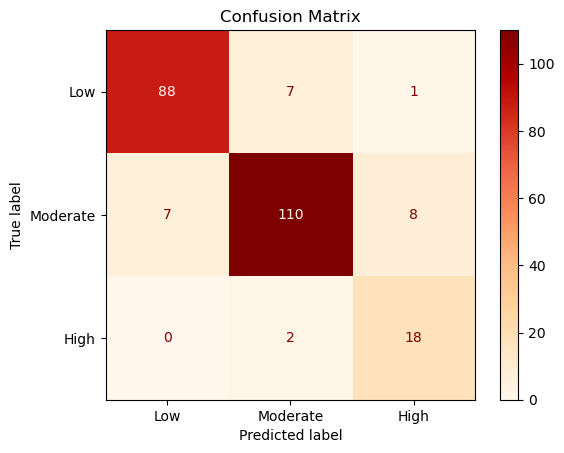

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Moderate', 'High'])
plt.figsize=(9,9)
disp.plot(cmap='OrRd', values_format='d')
plt.title('Confusion Matrix')
plt.show()


# Grid

In [11]:
# param_grid 
param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': [None, 'balanced_subsample', 'balanced']
}

# StratifiedKFold for CV (5 folds, stratify=y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV )
grid_search = GridSearchCV(
    pipeline, param_grid, 
    cv=skf, 
    scoring='f1_macro',  # optimizing F1 (for class balance)
    n_jobs=-1,  
    verbose=1 
)

# grid swarch
grid_search.fit(X, y)

# best params
print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

# Report with best parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("\nClassification Report with best parameters:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best macro F1: 0.8897182351144896

Classification Report with best parameters:
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.93      0.91      0.92       125
        High       0.81      0.85      0.83        20

    accuracy                           0.92       241
   macro avg       0.89      0.90      0.89       241
weighted avg       0.92      0.92      0.92       241



In [12]:
cm_oh = confusion_matrix(y_pred=y_pred, y_true = y_test)

# CV+SMOTE for BASE CLF

In [13]:
smote = SMOTE(k_neighbors=2, random_state=42)

smote_pipeline = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('smote', smote),
                            ('classifier', base_clf)
])

In [14]:
# CV
def cv_with_smote(X, y, pipeline, n_splits=5):
    """Custom CV with smote"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {
            'fold': [],
            'f1_macro': [],
            'f1_weighted': [],
            'precision': [],
            'recall': [],
            'class_0': [],
            'class_1': [],
            'class_2': []
    }
    
    print(f"\nRunning {n_splits}-fold Cross-Validation...")
    print("-" * 70)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
        y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)
        
        # Train pipeline (SMOTE only for X_train!)
        pipeline.fit(X_train, y_train)
        
        # test predictions
        y_pred = pipeline.predict(X_test)
        
        # metrics
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # classification report 
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        # Results
        results['fold'].append(fold + 1)
        results['f1_macro'].append(f1_macro)
        results['f1_weighted'].append(f1_weighted)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['class_0'].append(report['0']['f1-score'])
        results['class_1'].append(report['1']['f1-score'])
        results['class_2'].append(report['2']['f1-score'])
        
        print(f"Fold {fold + 1}: F1-macro={f1_macro:.3f}, F1-weighted={f1_weighted:.3f}, Recall={recall:.3f}")
    
    return pd.DataFrame(results)

In [15]:
cv_results = cv_with_smote(X, y, smote_pipeline, n_splits=5)


Running 5-fold Cross-Validation...
----------------------------------------------------------------------
Fold 1: F1-macro=0.873, F1-weighted=0.902, Recall=0.900
Fold 2: F1-macro=0.868, F1-weighted=0.909, Recall=0.905
Fold 3: F1-macro=0.915, F1-weighted=0.948, Recall=0.946
Fold 4: F1-macro=0.812, F1-weighted=0.856, Recall=0.851
Fold 5: F1-macro=0.827, F1-weighted=0.853, Recall=0.851


In [16]:
print("\n" + "=" * 70)
print("Cross-Validation Results")
print("=" * 70)
print(cv_results.to_string(index=False))

print("\n" + "=" * 70)
print("Statistics")
print("=" * 70)
print(f"F1-macro:    {cv_results['f1_macro'].mean():.3f} ± {cv_results['f1_macro'].std():.3f}")
print(f"F1-weighted: {cv_results['f1_weighted'].mean():.3f} ± {cv_results['f1_weighted'].std():.3f}")
print(f"Precision:   {cv_results['precision'].mean():.3f} ± {cv_results['precision'].std():.3f}")
print(f"Recall:      {cv_results['recall'].mean():.3f} ± {cv_results['recall'].std():.3f}")

print(f"\nFor each class (F1-score):")
print(f"  Low: {cv_results['class_0'].mean():.3f} ± {cv_results['class_0'].std():.3f}")
print(f"  Moderate: {cv_results['class_1'].mean():.3f} ± {cv_results['class_1'].std():.3f}")
print(f"  High: {cv_results['class_2'].mean():.3f} ± {cv_results['class_2'].std():.3f}")


Cross-Validation Results
 fold  f1_macro  f1_weighted  precision   recall  class_0  class_1  class_2
    1  0.873034     0.901630   0.912159 0.900415 0.930000 0.897436 0.791667
    2  0.868283     0.908916   0.923114 0.904564 0.941799 0.908333 0.754717
    3  0.915243     0.947687   0.952036 0.946058 0.968421 0.951220 0.826087
    4  0.811527     0.856199   0.873054 0.850622 0.877005 0.866667 0.690909
    5  0.827071     0.853213   0.868151 0.850622 0.871795 0.854701 0.754717

Statistics
F1-macro:    0.859 ± 0.041
F1-weighted: 0.894 ± 0.040
Precision:   0.906 ± 0.035
Recall:      0.890 ± 0.041

For each class (F1-score):
  Low: 0.918 ± 0.042
  Moderate: 0.896 ± 0.038
  High: 0.764 ± 0.050


# RF with One-Hot Encoding

In [17]:
df_oh = df.copy()

In [18]:
le = LabelEncoder()
df_oh['Adaptivity Level'] = le.fit_transform(df_oh['Adaptivity Level'])  # 0=Low, 1=Moderate, 2=High

In [19]:
display(style_table(df_oh.head()))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,1
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,1
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,1
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,0


In [20]:
X = df_oh.drop('Adaptivity Level', axis=1)
y = df_oh['Adaptivity Level']

X_oh = pd.get_dummies(X, dtype='float')
X_oh.head()

,Gender_Boy,Gender_Girl,Age_1-5,Age_11-15,Age_16-20,Age_21-25,Age_26-30,Age_6-10,Education Level_College,Education Level_School,...,Network Type_3G,Network Type_4G,Class Duration_0,Class Duration_1-3,Class Duration_3-6,Self Lms_No,Self Lms_Yes,Device_Computer,Device_Mobile,Device_Tab
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [21]:

X_train, X_test, y_train, y_test = train_test_split(X_oh, y, shuffle=True, stratify=y, test_size=0.2)

oh_rf_clf = RandomForestClassifier()
oh_rf_clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
# prediction
y_pred = oh_rf_clf.predict(X_test)

# Report
print("Classification Report для RF з one-hot:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']))

# Importance (top-10 feachures, with one-hot)
importance = pd.DataFrame({
    'feature': X_oh.columns,
    'importance': oh_rf_clf.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print("\nTop-10 features by importance:")
print(importance)

Classification Report для RF з one-hot:
              precision    recall  f1-score   support

         Low       0.90      0.96      0.93        96
    Moderate       0.93      0.92      0.93       125
        High       0.88      0.70      0.78        20

    accuracy                           0.92       241
   macro avg       0.90      0.86      0.88       241
weighted avg       0.92      0.92      0.92       241


Top-10 features by importance:
                            feature  importance
27                 Class Duration_0    0.075091
0                        Gender_Boy    0.043513
1                       Gender_Girl    0.043155
19          Financial Condition_Mid    0.041604
12  Institution Type_Non Government    0.036692
28               Class Duration_1-3    0.036041
20         Financial Condition_Poor    0.034358
26                  Network Type_4G    0.034108
25                  Network Type_3G    0.033675
10       Education Level_University    0.032187


# CV+SMOTE for NEW CLF

In [23]:
new_clf = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
smote_pipeline_new = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('smote', smote),
                            ('classifier', new_clf)
])
cv_results_new = cv_with_smote(X, y, smote_pipeline_new, n_splits=5)


Running 5-fold Cross-Validation...
----------------------------------------------------------------------
Fold 1: F1-macro=0.873, F1-weighted=0.902, Recall=0.900
Fold 2: F1-macro=0.868, F1-weighted=0.909, Recall=0.905
Fold 3: F1-macro=0.912, F1-weighted=0.943, Recall=0.942
Fold 4: F1-macro=0.818, F1-weighted=0.865, Recall=0.859
Fold 5: F1-macro=0.827, F1-weighted=0.853, Recall=0.851


In [24]:
print("\n" + "=" * 70)
print("CV for SMOTE Model")
print("=" * 70)
print(cv_results_new.to_string(index=False))

print("\n" + "=" * 70)
print("Statistics")
print("=" * 70)
print(f"F1-macro:    {cv_results_new['f1_macro'].mean():.3f} ± {cv_results_new['f1_macro'].std():.3f}")
print(f"F1-weighted: {cv_results_new['f1_weighted'].mean():.3f} ± {cv_results_new['f1_weighted'].std():.3f}")
print(f"Precision:   {cv_results_new['precision'].mean():.3f} ± {cv_results_new['precision'].std():.3f}")
print(f"Recall:      {cv_results_new['recall'].mean():.3f} ± {cv_results_new['recall'].std():.3f}")

print(f"\nFor each class (F1-score):")
print(f"  Low: {cv_results_new['class_0'].mean():.3f} ± {cv_results_new['class_0'].std():.3f}")
print(f"  Moderate: {cv_results_new['class_1'].mean():.3f} ± {cv_results_new['class_1'].std():.3f}")
print(f"  High: {cv_results_new['class_2'].mean():.3f} ± {cv_results_new['class_2'].std():.3f}")


CV for SMOTE Model
 fold  f1_macro  f1_weighted  precision   recall  class_0  class_1  class_2
    1  0.873034     0.901630   0.912159 0.900415 0.930000 0.897436 0.791667
    2  0.868283     0.908916   0.923114 0.904564 0.941799 0.908333 0.754717
    3  0.912107     0.943372   0.948044 0.941909 0.963731 0.946502 0.826087
    4  0.817916     0.864710   0.882204 0.858921 0.888889 0.873950 0.690909
    5  0.827071     0.853213   0.868151 0.850622 0.871795 0.854701 0.754717

Statistics
F1-macro:    0.860 ± 0.038
F1-weighted: 0.894 ± 0.036
Precision:   0.907 ± 0.032
Recall:      0.891 ± 0.037

For each class (F1-score):
  Low: 0.919 ± 0.038
  Moderate: 0.896 ± 0.035
  High: 0.764 ± 0.050


# XGB

In [25]:
# Pipeline for XGB
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'))  
])

# Params XGB
param_grid_xgb = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__learning_rate': [0.05, 0.1, 0.2],  # key XGB
    'classifier__subsample': [0.8, 1.0],
    'classifier__min_child_weight': [1, 2, 4],  # min_samples_leaf analog
    'classifier__scale_pos_weight': [1, 2]  # data imbalanse (weigh for High)
}

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for XGB
grid_xgb = GridSearchCV(
    pipeline_xgb, param_grid_xgb, 
    cv=skf, scoring='f1_macro', 
    n_jobs=-1, verbose=1
)

# Fit
grid_xgb.fit(X, y)

# Best params
print("Best XGB parameters:", grid_xgb.best_params_)
print("Best macro F1:", grid_xgb.best_score_)

# Report for test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_xgb = grid_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
print("\nClassification Report for XGB model:")
print(classification_report(y_test, y_pred_xgb, target_names=['Low', 'Moderate', 'High']))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:43:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}
Best macro F1: 0.8935625116039085


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:43:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report for XGB model:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.92        96
    Moderate       0.91      0.91      0.91       125
        High       0.81      0.85      0.83        20

    accuracy                           0.91       241
   macro avg       0.88      0.89      0.89       241
weighted avg       0.91      0.91      0.91       241



# VotingModel

In [26]:
# RF + XGB + hyperparameters tuning
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
xgb_base = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42, scale_pos_weight=2)

# Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base)
    ],
    voting='soft'  # 'hard' for voting, 'soft' for probabilities
)

# Pipeline for ensem.
pipeline_ensemble = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# Hyperparameters tuning (ens)
param_grid_ensemble = {
    'ensemble__rf__n_estimators': [100, 300],
    'ensemble__rf__max_depth': [10, 20],
    'ensemble__xgb__n_estimators': [300, 500],
    'ensemble__xgb__max_depth': [10, 20],
    'ensemble__xgb__learning_rate': [0.05, 0.1]
}

# GridSearchCV (ens)
grid_ensemble = GridSearchCV(
    pipeline_ensemble, param_grid_ensemble, 
    cv=skf, scoring='f1_macro', 
    n_jobs=-1, verbose=1
)

# Fit
grid_ensemble.fit(X, y)

# Best params
print("Ensemble best parameters:", grid_ensemble.best_params_)
print("Ensemble best macro F1:", grid_ensemble.best_score_)

# Report for test data
best_ensemble = grid_ensemble.best_estimator_
best_ensemble.fit(X_train, y_train)
y_pred_ens = best_ensemble.predict(X_test)
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ens, target_names=['Low', 'Moderate', 'High']))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble best parameters: {'ensemble__rf__max_depth': 10, 'ensemble__rf__n_estimators': 300, 'ensemble__xgb__learning_rate': 0.1, 'ensemble__xgb__max_depth': 20, 'ensemble__xgb__n_estimators': 500}
Ensemble best macro F1: 0.8887273606969144


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.92        96
    Moderate       0.91      0.91      0.91       125
        High       0.81      0.85      0.83        20

    accuracy                           0.91       241
   macro avg       0.88      0.89      0.89       241
weighted avg       0.91      0.91      0.91       241



In [27]:
#  importance for RF
rf_clf = best_ensemble.named_steps['ensemble'].named_estimators_['rf']
rf_import = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

# importance for XGB
xgb_clf = best_ensemble.named_steps['ensemble'].named_estimators_['xgb']
xgb_import = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Top-10
print("RF Importance (top-10):\n", rf_import.head(10))
print("\nXGB Importance (top-10):\n", xgb_import.head(10))

RF Importance (top-10):
                 feature  importance
7   Financial Condition    0.190314
10       Class Duration    0.141239
1                   Age    0.134412
0                Gender    0.077590
9          Network Type    0.066103
3      Institution Type    0.063892
2       Education Level    0.057723
5              Location    0.056790
8         Internet Type    0.048753
11             Self Lms    0.046307

XGB Importance (top-10):
                 feature  importance
10       Class Duration    0.200703
5              Location    0.091198
7   Financial Condition    0.081006
11             Self Lms    0.077082
4            IT Student    0.074838
3      Institution Type    0.073733
1                   Age    0.072619
2       Education Level    0.062587
0                Gender    0.058832
9          Network Type    0.054189


In [28]:
rf_import.head(15)
#rf_import_features = rf_import.set_index('feature')
#rf_import_features.head()

,feature,importance
7,Financial Condition,0.190314
10,Class Duration,0.141239
1,Age,0.134412
0,Gender,0.077590
9,Network Type,0.066103
3,Institution Type,0.063892
2,Education Level,0.057723
5,Location,0.056790
8,Internet Type,0.048753
11,Self Lms,0.046307


In [29]:
xgb_import_features = xgb_import.set_index('feature')
xgb_import_features.head()

,importance
feature,
Class Duration,0.200703
Location,0.091198
Financial Condition,0.081006
Self Lms,0.077082
IT Student,0.074838


In [30]:
merged_df = pd.merge(rf_import, xgb_import, left_index=True, right_index=True, how='inner').sort_index().set_index('feature_x').drop('feature_y', axis=1)
merged_df.rename(columns={'importance_x': 'importance_rf', 'importance_y': 'importance_xgb'}, inplace=True)


In [31]:
merged_df = merged_df.sort_values(by='importance_rf', ascending=True)
merged_df.head()

,importance_rf,importance_xgb
feature_x,,
Load-shedding,0.036634,0.050520
IT Student,0.037920,0.074838
Device,0.042323,0.050002
Self Lms,0.046307,0.077082
Internet Type,0.048753,0.052692


In [32]:
plt.style.use('seaborn-v0_8-paper')

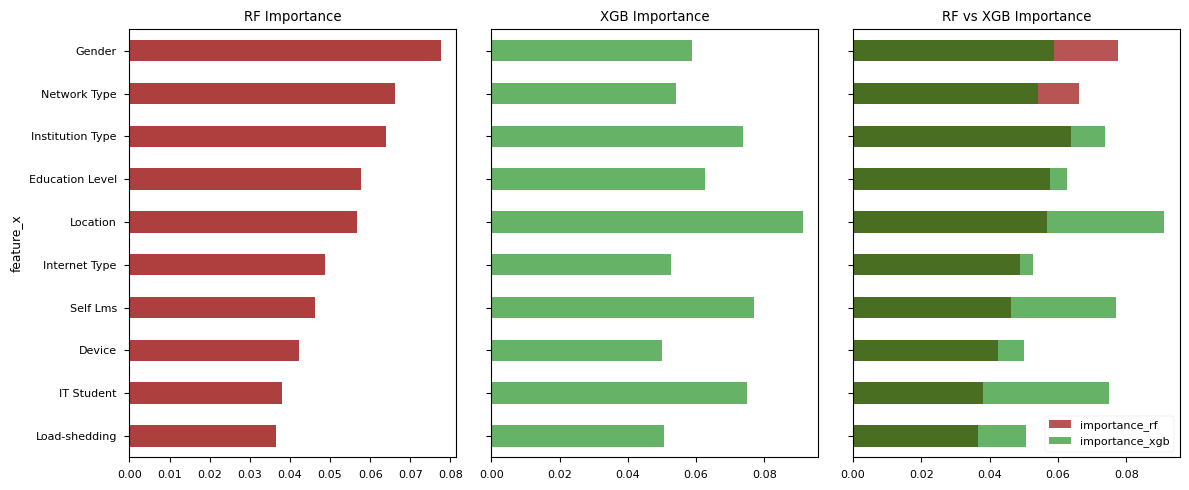

In [33]:
# Visualization

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
merged_df['importance_rf'].head(10).plot(kind='barh', ax=ax[0], title='RF Importance', color='brown', alpha=0.9)
merged_df['importance_xgb'].head(10).plot(kind='barh', ax=ax[1], title='XGB Importance', color='green', alpha=0.6)
merged_df['importance_rf'].head(10).plot(kind='barh', ax=ax[2], title='RF vs XGB Importance', color='brown', alpha=0.8)
merged_df['importance_xgb'].head(10).plot(kind='barh', ax=ax[2], color='green', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

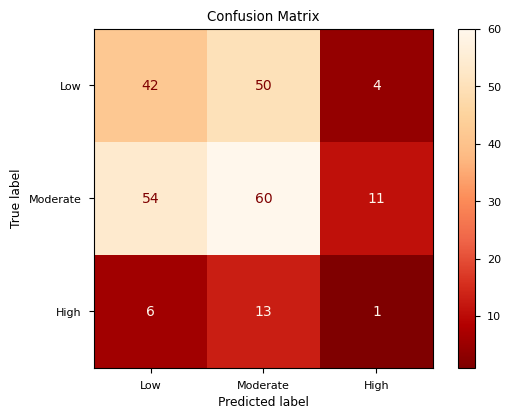

In [34]:
cm_voting = confusion_matrix(y_test, y_pred, labels=y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=['Low', 'Moderate', 'High'])
plt.figsize=(9,9)
disp.plot(cmap='OrRd_r', values_format='d')
plt.title('Confusion Matrix')
plt.show()


# Other insights

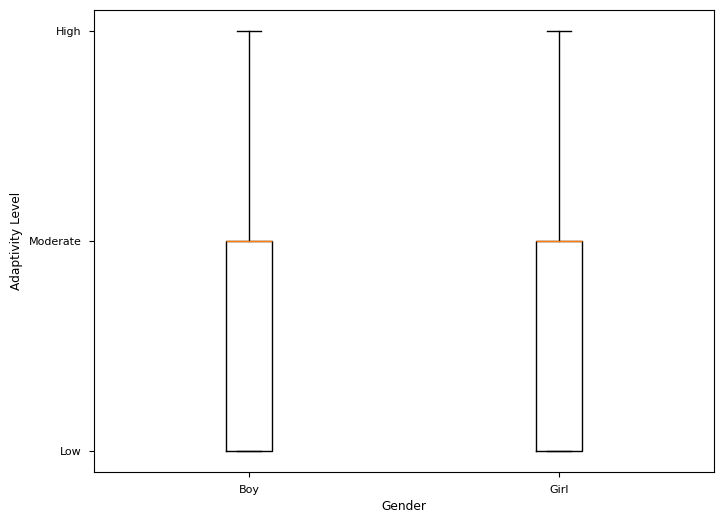

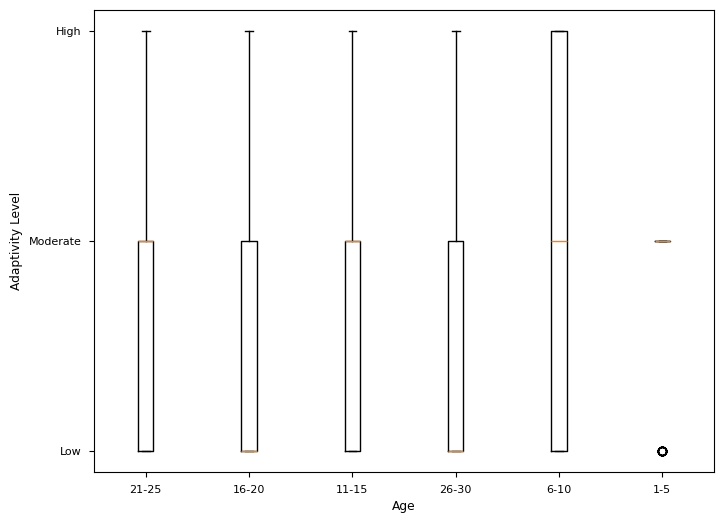

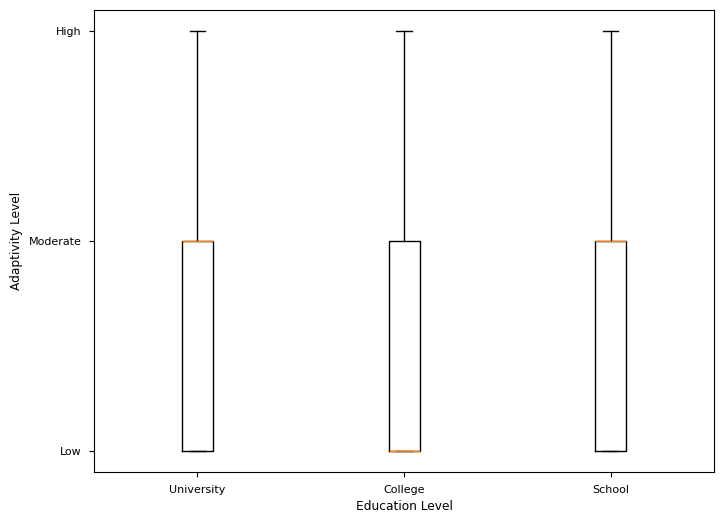

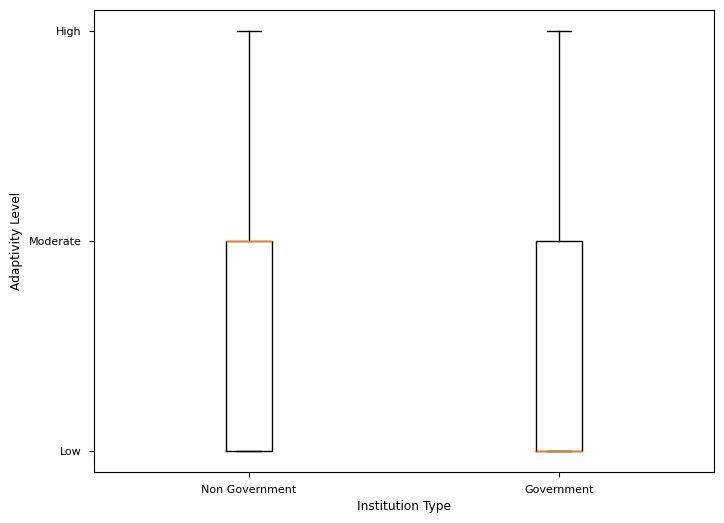

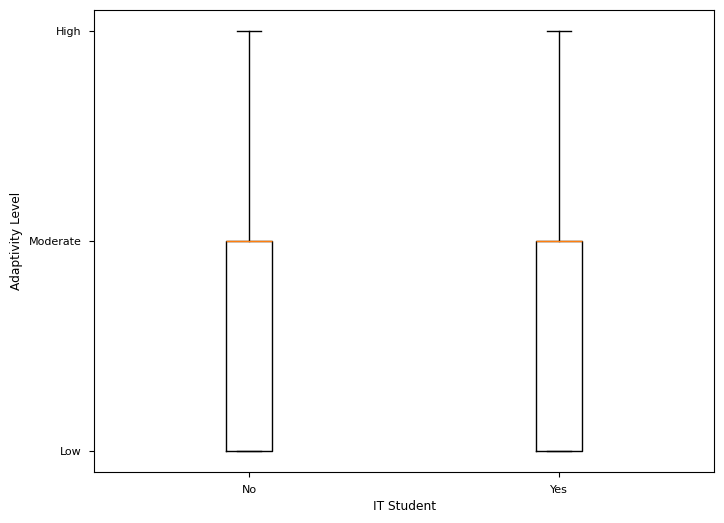

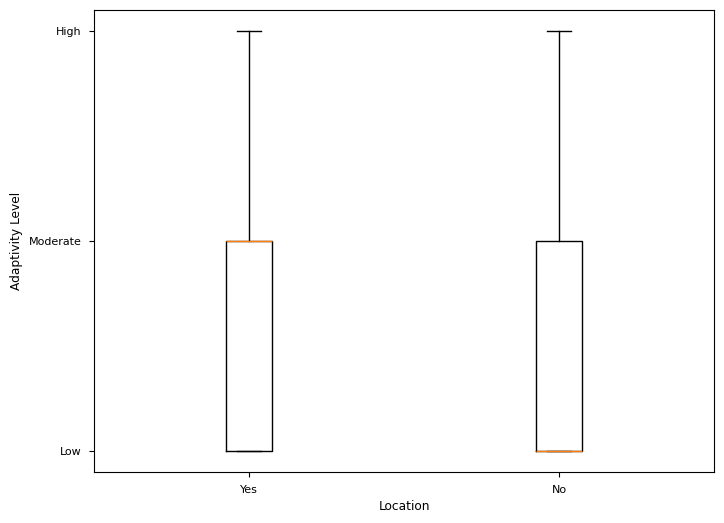

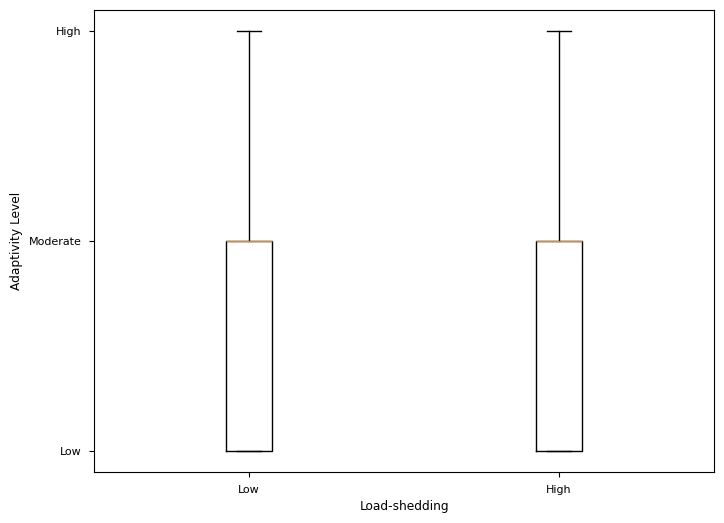

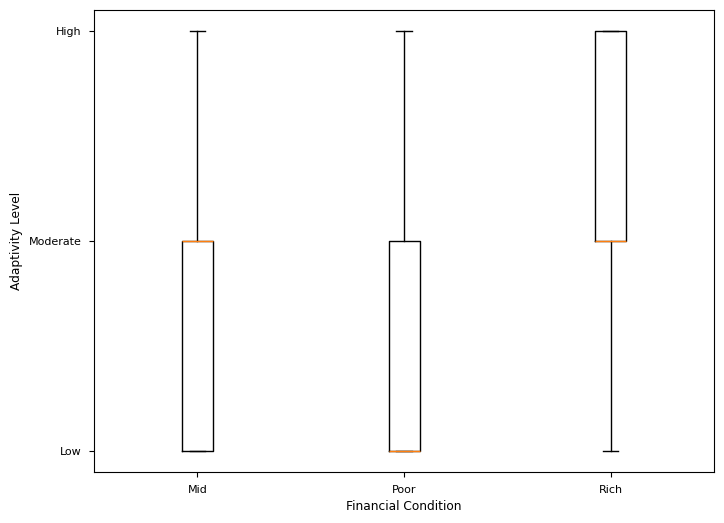

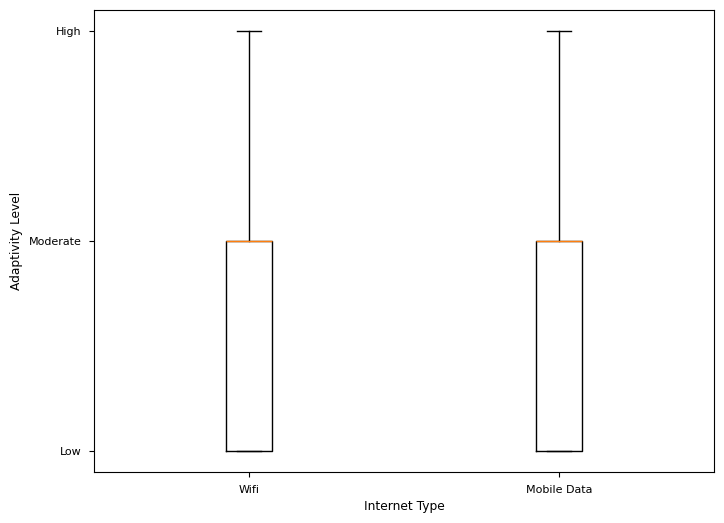

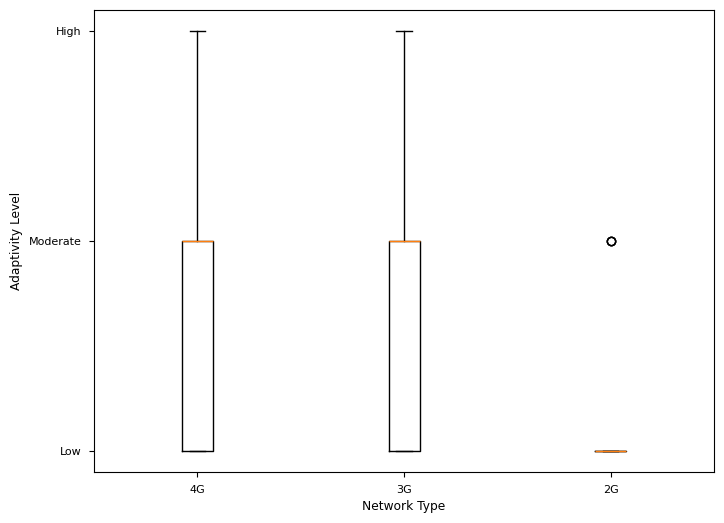

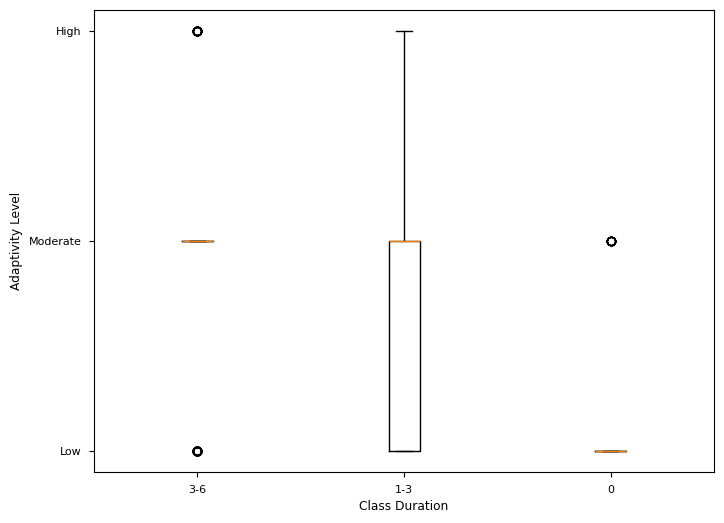

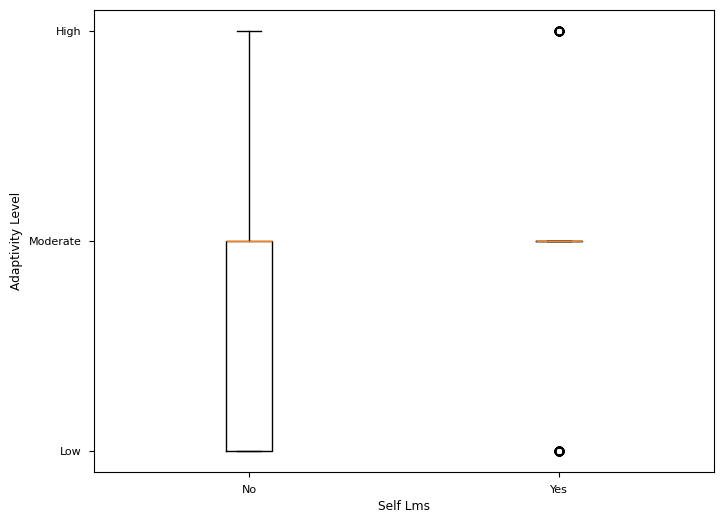

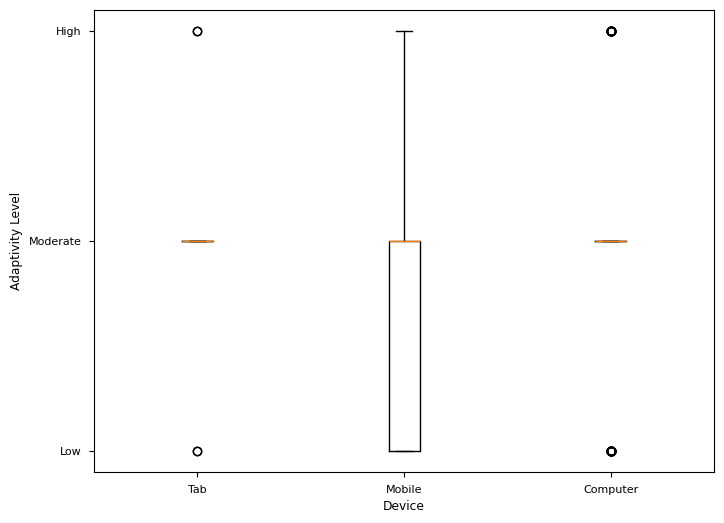

In [35]:
def boxplot(df, c):
    c_unique = df[c].unique()
    plt.figure(figsize=(8, 6))
    for i in range(len(c_unique)):
        plt.boxplot(df[df[c]==c_unique[i]]['Adaptivity Level'], positions=[i])
        plt.xticks(ticks=range(len(c_unique)), labels=c_unique)
        plt.yticks(ticks=[0,1,2], labels=['Low', 'Moderate', 'High'])
        plt.xlabel(str(c))
        plt.ylabel('Adaptivity Level')
        
for c in df.columns[:-1]:
    boxplot(df, c)

In [36]:
pipeline_rf = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('classifier', new_clf)               
                           ])

pipeline_rf.fit(X_train, y_train)

rf_best_model = pipeline_rf.named_steps['classifier']

X_test_transformed = pipeline_rf.named_steps['preprocessor'].transform(X_test)

explainer =  shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_test_transformed)

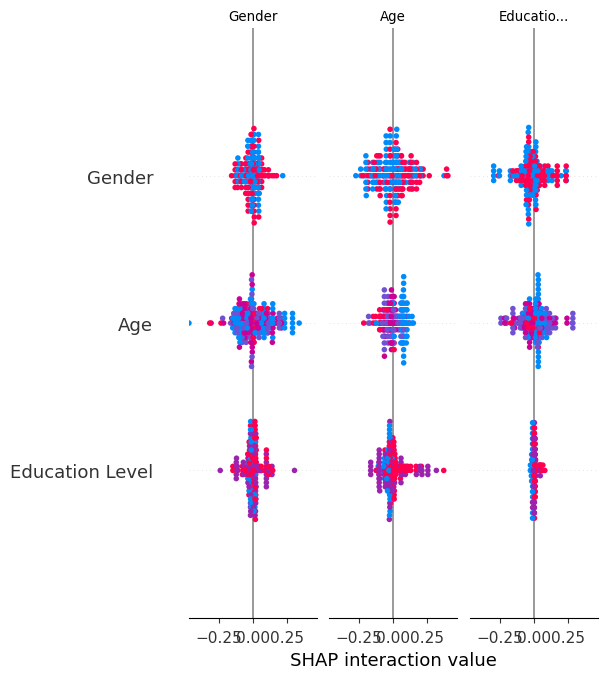

In [37]:
feature_names = list(map(lambda x: x.strip('cat_'), pipeline.named_steps['preprocessor'].get_feature_names_out()))

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, class_names=['Low', 'Moderate', 'High'])

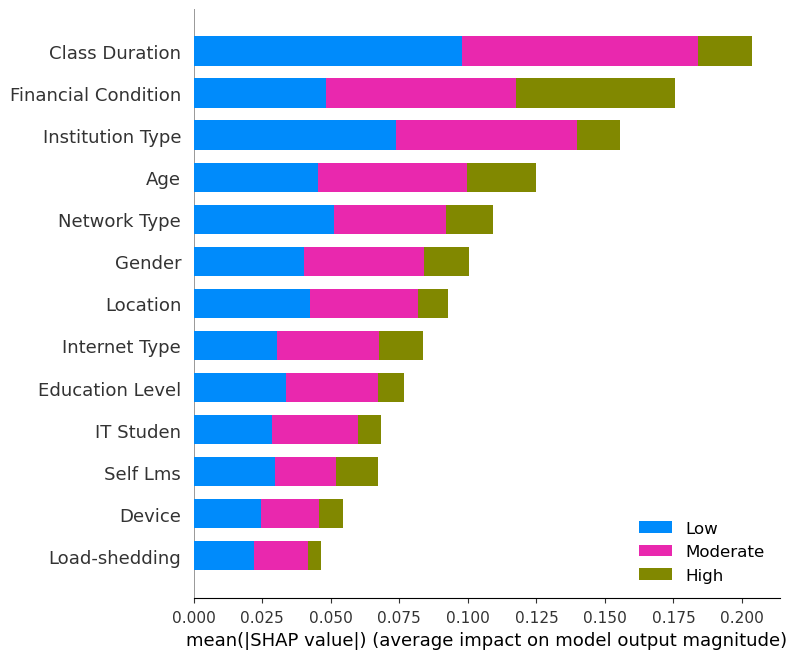

In [38]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type='bar', class_names=['Low', 'Moderate', 'High'])